In [2]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt

from patchify import patchify,unpatchify
import tifffile as tiff
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

import geopandas as gpd
import rasterio
from rasterio import mask
from rasterio.io import MemoryFile
from rasterio.windows import transform, Window
from rasterio.features import dataset_features
from typing import List, Any, Tuple
import PIL
from skimage import exposure
from skimage import data, io, filters



Segmentation Models: using `keras` framework.


Reading Vector file (.shp), Converting vector file (.shp format) to a numpy array of type geometry and Generate a binary mask from raster and vector pairs

In [5]:
def mask_raster(raster: rasterio.io.DatasetReader, geometry_objects: np.ndarray) -> Tuple[Any, Any]:

    return mask.raster_geometry_mask(raster, geometry_objects, invert=True)

In [6]:
path = "C:/Users/ayxan/anaconda3/azercosmos_project/train/"
path_mask= "C:/Users/ayxan/anaconda3/azercosmos_project/mask/"
for infile in os.listdir(path):
    if infile.endswith('.shp'):

        vector_file = gpd.read_file(path + infile)
        geometry_objects = np.array(vector_file['geometry'].values)
        
        outfile = infile.split('.')[0] + '.tif'
        raster_file_path: str = path+outfile
      
        src = rasterio.open(raster_file_path, mode='r')
        binary_mask,_,_=mask_raster(src, geometry_objects)
        
        x,y=binary_mask.shape
        new_binary_mask = np.zeros((x,y,3),dtype='uint8')

        for i in range(len(binary_mask)):
            for j in range(len(binary_mask[i])):
                if binary_mask[i][j] ==True:
                    new_binary_mask[i][j]=1
                else:
                    new_binary_mask[i][j]=0

        file = path_mask+ outfile
        io.imsave(file,new_binary_mask)

C:\Users\ayxan\AppData\Local\Temp\ipykernel_1076\1158801637.py:26: UserWarning: C:/Users/ayxan/anaconda3/azercosmos_project/mask/sample_1.tif is a low contrast image
  io.imsave(file,new_binary_mask)
C:\Users\ayxan\AppData\Local\Temp\ipykernel_1076\1158801637.py:26: UserWarning: C:/Users/ayxan/anaconda3/azercosmos_project/mask/sample_10.tif is a low contrast image
  io.imsave(file,new_binary_mask)
C:\Users\ayxan\AppData\Local\Temp\ipykernel_1076\1158801637.py:26: UserWarning: C:/Users/ayxan/anaconda3/azercosmos_project/mask/sample_11.tif is a low contrast image
  io.imsave(file,new_binary_mask)
C:\Users\ayxan\AppData\Local\Temp\ipykernel_1076\1158801637.py:26: UserWarning: C:/Users/ayxan/anaconda3/azercosmos_project/mask/sample_12.tif is a low contrast image
  io.imsave(file,new_binary_mask)
C:\Users\ayxan\AppData\Local\Temp\ipykernel_1076\1158801637.py:26: UserWarning: C:/Users/ayxan/anaconda3/azercosmos_project/mask/sample_13.tif is a low contrast image
  io.imsave(file,new_binary_ma

preparing data for training

In [7]:
path = "C:/Users/ayxan/anaconda3/azercosmos_project/train/"
new_path = "C:/Users/ayxan/anaconda3/azercosmos_project/images/"
for infile in os.listdir(path):
    if infile.endswith('.tif'):
        read = cv2.imread(path + infile, -1)
        cv2.imwrite(new_path + infile, read)
        
for infile in os.listdir(new_path):
        image = cv2.imread(new_path + infile)
        channels = cv2.split(image)
        eq_channels = []
        for ch, color in zip(channels, ['B', 'G', 'R']):
            eq_channels.append(cv2.equalizeHist(ch))
        eq_image = cv2.merge(eq_channels)
        cv2.imwrite(new_path + infile, eq_image)

In [8]:
patch_size=256
image_path='C:/Users/ayxan/anaconda3/azercosmos_project/images/'
for image_name in os.listdir(image_path):
    if image_name.endswith('.tif'):
        image = cv2.imread(image_path+image_name,1)
        SIZE_X=(image.shape[1]//patch_size)*patch_size
        SIZE_Y=(image.shape[0]//patch_size)*patch_size
        image=PIL.Image.fromarray(image)
        image=image.crop((0,0,SIZE_X,SIZE_Y))
        image=np.array(image)
        patches_img= patchify(image,(128,128,3),step=128)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_image=patches_img[i,j,:,:]

                single_patch_image=single_patch_image[0]
                cv2.imwrite("C:/Users/ayxan/anaconda3/azercosmos_project/patch_images/image/"+str(i)+str(j)+image_name,single_patch_image)

image_path='C:/Users/ayxan/anaconda3/azercosmos_project/mask/'
for image_name in os.listdir(image_path):
    if image_name.endswith('.tif'):
        image = cv2.imread(image_path+image_name,1)
        SIZE_X=(image.shape[1]//patch_size)*patch_size
        SIZE_Y=(image.shape[0]//patch_size)*patch_size
        image=PIL.Image.fromarray(image)
        image=image.crop((0,0,SIZE_X,SIZE_Y))
        image=np.array(image)
        patches_img= patchify(image,(128,128,3),step=128)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_image=patches_img[i,j,:,:]

                single_patch_image=single_patch_image[0]
                cv2.imwrite("C:/Users/ayxan/anaconda3/azercosmos_project/patch_images/mask/"+str(i)+str(j)+image_name,single_patch_image)
                    

In [9]:
file_path="C:/Users/ayxan/anaconda3/azercosmos_project/patch_images/"
for folder in os.listdir(file_path):
    files=os.listdir(file_path+folder)
    file_num= len(os.listdir(file_path+folder))
    num=int(file_num*0.20)

    for i in range(file_num-num):
        file_name=files[i]
        train_path='C:/Users/ayxan/anaconda3/azercosmos_project/data/'

        if folder=='image':
            folder_name='train_images/train/'
            image=cv2.imread(file_path+folder+'/'+file_name,1)
            cv2.imwrite(train_path+folder_name+file_name,image)
            
        elif folder=='mask':
            folder_name='train_masks/train/'
            image=cv2.imread(file_path+folder+'/'+file_name,0)
            cv2.imwrite(train_path+folder_name+file_name,image)

            
    for i in range(file_num-num,file_num):        
        file_name=files[i]
        train_path='C:/Users/ayxan/anaconda3/azercosmos_project/data/'
        
        if folder=='image':
            folder_name='val_images/valid/'
            image=cv2.imread(file_path+folder+'/'+file_name,1)
            cv2.imwrite(train_path+folder_name+file_name,image)
        elif folder=='mask':
            folder_name='val_masks/valid/'
            image=cv2.imread(file_path+folder+'/'+file_name,0)
            cv2.imwrite(train_path+folder_name+file_name,image)

Training


In [10]:
#gpu support
physical_devices=tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs available:', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs available: 1


In [11]:
seed=24
batch_size= 16
n_classes=2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img) 
    mask = to_categorical(mask, num_class)
    
    return (img,mask)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)

        yield (img, mask)


train_img_path = "C:/Users/ayxan/anaconda3/azercosmos_project/data/train_images/"
train_mask_path = "C:/Users/ayxan/anaconda3/azercosmos_project/data/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=2)

val_img_path = "C:/Users/ayxan/anaconda3/azercosmos_project/data/val_images/"
val_mask_path = "C:/Users/ayxan/anaconda3/azercosmos_project/data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=2)


x, y = train_img_gen.__next__()
x_val,y_val = val_img_gen.__next__()

Found 631 images belonging to 1 classes.
Found 631 images belonging to 1 classes.
Found 157 images belonging to 1 classes.
Found 157 images belonging to 1 classes.


In [23]:
seed=24
batch_size= 16
n_classes=2
BACKBONE = 'resnet34'

main_path='C:/Users/ayxan/anaconda3/azercosmos_project/'
num_train_imgs=len(os.listdir(main_path+"data/train_images/train/"))
num_valid_imgs=len(os.listdir(main_path+"data/val_images/valid/"))
steps_per_epochs=num_train_imgs//batch_size
val_steps_epochs=num_valid_imgs//batch_size

IMG_HEIGHT=x.shape[1]
IMG_WIDTH=x.shape[2]
IMG_CHANNELS=x.shape[3]


model = sm.Unet(BACKBONE, encoder_weights='imagenet',
               input_shape=(IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),
               classes=n_classes, activation='softmax')

model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss,
             metrics=[sm.metrics.iou_score])
print(model.summary())
print(model.input_shape)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

 zero_padding2d_40 (ZeroPadding  (None, 66, 66, 64)  0           ['stage1_unit3_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 64, 64, 64)   36864       ['zero_padding2d_40[0][0]']      
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 64, 64, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 64, 64, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
          

 zation)                                                                                          
                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 32, 32, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_47 (ZeroPadding  (None, 34, 34, 128)  0          ['stage2_unit3_relu2[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 32, 32, 128)  147456      ['zero_padding2d_47[0][0]']      
                                                                                                  
 add_21 (A

 2D)                                                                                              
                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_53[0][0]']      
                                                                                                  
 add_24 (Add)                   (None, 16, 16, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_23[0][0]']                 
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 16, 16, 256)  1024       ['add_24[0][0]']                 
 zation)                                                                                          
                                                                                                  
 stage3_un

 zation)                                                                                          
                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_60 (ZeroPadding  (None, 18, 18, 256)  0          ['stage3_unit6_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_60[0][0]']      
                                                                                                  
 stage3_un

 2D)                                                                                              
                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 8, 8, 512)    2359296     ['zero_padding2d_66[0][0]']      
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 8, 8, 512)   2048        ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 8, 8, 512)   0           ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

 decoder_stage2b_conv (Conv2D)  (None, 64, 64, 64)   36864       ['decoder_stage2a_relu[0][0]']   
                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 64, 64, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 64, 64, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 128, 128, 64  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     )                                                                 
          

strat training

In [24]:
history=model.fit(train_img_gen,
                 steps_per_epoch=steps_per_epochs,
                 epochs=40,
                  verbose=1,
                  validation_data=val_img_gen,
                  validation_steps=val_steps_epochs)

Epoch 1/40
39/39 [==============================] - 12s 244ms/step - loss: 0.2832 - iou_score: 0.7284 - val_loss: 2.3420 - val_iou_score: 0.1346
Epoch 2/40
39/39 [==============================] - 9s 231ms/step - loss: 0.1519 - iou_score: 0.8688 - val_loss: 1.9563 - val_iou_score: 0.2508
Epoch 3/40
39/39 [==============================] - 9s 230ms/step - loss: 0.0976 - iou_score: 0.9177 - val_loss: 2.3219 - val_iou_score: 0.1364
Epoch 4/40
39/39 [==============================] - 9s 231ms/step - loss: 0.0770 - iou_score: 0.9348 - val_loss: 2.2958 - val_iou_score: 0.1422
Epoch 5/40
39/39 [==============================] - 9s 231ms/step - loss: 0.0768 - iou_score: 0.9364 - val_loss: 1.2670 - val_iou_score: 0.1471
Epoch 6/40
39/39 [==============================] - 9s 231ms/step - loss: 0.0774 - iou_score: 0.9355 - val_loss: 2.1176 - val_iou_score: 0.1388
Epoch 7/40
39/39 [==============================] - 9s 232ms/step - loss: 0.0724 - iou_score: 0.9391 - val_loss: 1.2789 - val_iou_score

saving training model

In [47]:
model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

plot the training and validation IoU and loss at each epoch

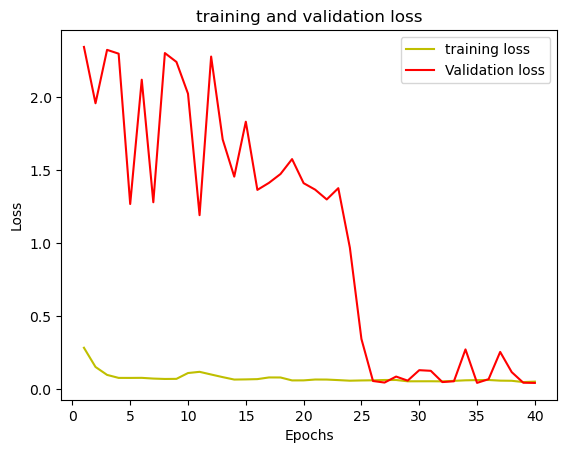

In [32]:
loss = history.history['loss']
val_loss= history.history['val_loss']
epochs=range(1,len(loss)+1)

plt.plot(epochs,loss,'y', label='training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

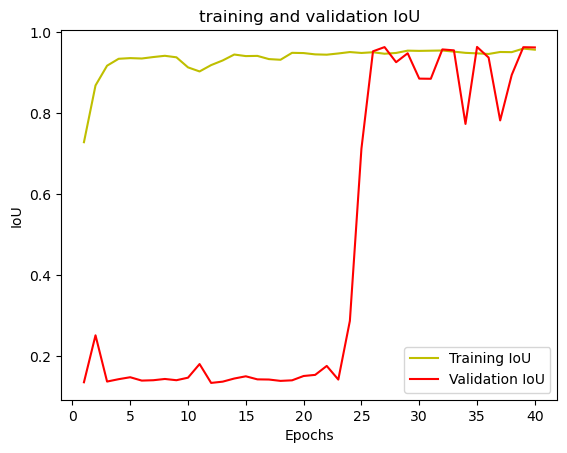

In [33]:
acc =history.history['iou_score']
val_acc=history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs,val_acc,'r', label='Validation IoU')
plt.title('training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel("IoU")
plt.legend()
plt.show()

predict on test image

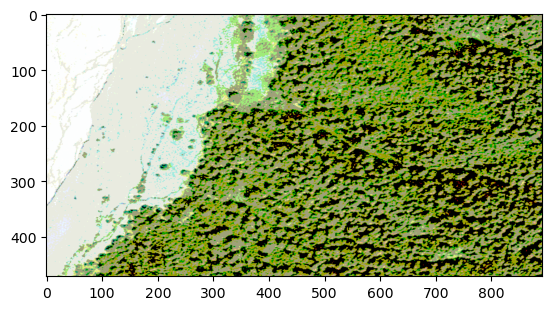

In [16]:
image=cv2.imread("test.tif")
channels=cv2.split(image)
eq_channels=[]
for ch, color in zip(channels,['B','G','R']):
    eq_channels.append(cv2.equalizeHist(ch))
eq_image = cv2.merge(eq_channels)
cv2.imwrite('equaz_test_img.tif',eq_image)
plt.imshow(eq_image)

1/1 [==============================] - 0s 19ms/step


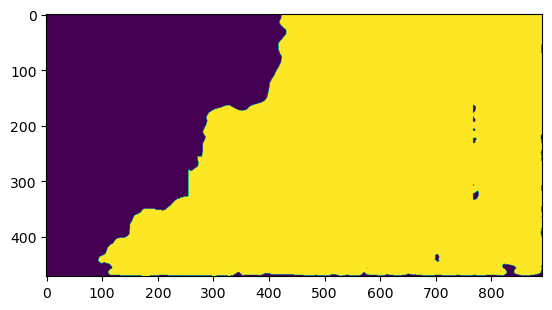

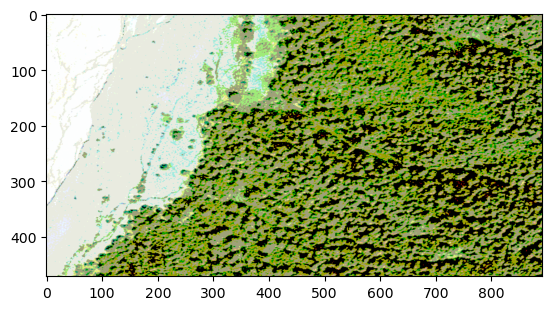

In [35]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

test_img=cv2.imread("equaz_test_img.tif",1)
h,w = test_img.shape[:2]

model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

patch_size=256
n_classes=2

SIZE_X=((test_img.shape[1]//patch_size)+1)*patch_size
SIZE_Y=((test_img.shape[0]//patch_size)+1)*patch_size
LARGE_image=PIL.Image.fromarray(test_img)
LARGE_image=LARGE_image.crop((0,0,SIZE_X,SIZE_Y))
LARGE_image=np.array(LARGE_image)

patches_img=patchify(LARGE_image,(patch_size,patch_size,3),step=patch_size)
patches_img=patches_img[:,:,0,:,:,:]

patched_production=[]
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img=patches_img[i,j,:,:,:]
        
        single_patch_img=scaler.fit_transform(single_patch_img.reshape
                                    (-1,single_patch_img.shape[-1])).reshape(single_patch_img.shape)

        single_patch_img=np.expand_dims(single_patch_img,axis=0)
        pred=model.predict(single_patch_img)
        pred=np.argmax(pred,axis=3)
        pred=pred[0,:,:]
        
        patched_production.append(pred)

patched_production=np.array(patched_production)
patched_production=np.reshape(patched_production, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_production=unpatchify(patched_production, (LARGE_image.shape[0], LARGE_image.shape[1]))

binary_array=np.zeros((h,w),dtype='uint16')
for i in range(h):
    for j in range(w):
        binary_array[i,j]=unpatched_production[i,j]
        
        
plt.imshow(binary_array)
plt.figure()
plt.imshow(test_img)
plt.show()

preparing shp file

In [36]:
def convert_array_to_vector(binary_mask: np.array, img_path: str) -> gpd.GeoDataFrame:
    """Convert masked array to vector file(.shp).

    Args:
        binary_mask: Output predicted binary mask.
        img_path: Path of the raster file used for the prediction.

    Returns:
        shp: GeoPandas DataFrame.

    """
    with rasterio.open(img_path, mode='r') as src:
        mask_meta = src.meta.copy()
        mask_meta.update(
            {
                'dtype': 'uint8',
                'count': 1,
                'nodata': 0.0               
            }
        )

        with MemoryFile() as memfile:
            with memfile.open(**mask_meta) as mem:
                mem.write_band(1, binary_mask)
                geoms = dataset_features(
                    mem,
                    geographic=True,
                    as_mask=True,
                    with_nodata=False
                )
                shp = gpd.GeoDataFrame.from_features(
                    geoms,
                    crs=str(mem.crs).lower(),
                    columns=['geometry', 'val']
                )
    return shp

In [37]:
raster_file_path='C:/Users/ayxan/anaconda3/azercosmos_project/test.tif'
converted_vector_file = convert_array_to_vector(binary_array, raster_file_path)
converted_vector_file

,geometry,val
0,"POLYGON ((47.63126 41.13739, 47.63779 41.13739...",255.0


In [38]:
def save_vector_file(shp: gpd.GeoDataFrame, dest_path: str) -> None:
    """Write vector file to the disk.

    Args:
        dest_path: Destionation path to save the vector file.
        shp: vector dataframe.

    """
    shp.to_file(dest_path)

In [39]:
save_vector_file(converted_vector_file, "test_shape.shp")

C:\Users\ayxan\anaconda3\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
